### Video-Based Gaze Tracking tutorial (4/5)
This is a lecture of the Video-Based Gaze Tracking tutorial of the [Bridging the Technological Gap Summer Workshop](https://psychandneuro.duke.edu/opportunity/bridging-technological-gap-summer-workshop), July 31st – August 6th, 2022, German Primate Center, Göttingen, Germany.

More info at [https://github.com/erkil1452/gaze_workshop_public](https://github.com/erkil1452/gaze_workshop_public).

Made by Petr Kellnhofer, 2022.

In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path('.').resolve().absolute().parent))

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import cv2
import imageio
import dlib
import nbimporter

# Automatically reload our library.
%reload_ext autoreload
%autoreload 1
from src import gaze_utils as gu
%aimport src

# Import solutions from our previous notebook(s).
from s01_capture import capture_frame, detect_face, crop_image
from s03_network import numpy_image_to_tensor, SimpleGazePredictor

DATA_PATH = Path('.').resolve().absolute().parent / 'data'
sample_data = gu.WorkshopDataset(DATA_PATH / 'gazecapture' / '00192')

## 4. Gaze prediction

In this section, we will learn how to train the network to predict gaze.

First, we will test our gaze network model from Sec. 3 and see what it does for our sample image.

torch.Size([1, 3, 127, 127])
The predicted gaze is tensor([-0.0579,  0.0250], grad_fn=<SelectBackward0>)


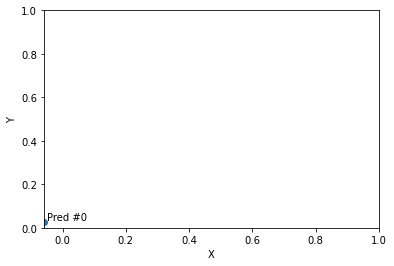

In [2]:
# Create our model and input from Section 3.
frame = sample_data.get_image(2)
net_input = numpy_image_to_tensor(crop_image(frame, detect_face(frame))).unsqueeze(0)
print(net_input.shape)
model = SimpleGazePredictor()

# Execute the model.
net_output = model(net_input)

# Print outputs.
print(f'The predicted gaze is {net_output[0]}')
gu.plot_gaze([net_output], ['Pred'])

Let's define a desired target gaze. This is a ground truth we would read from our training dataset or a true position of a target in a tracker calibration session.

Since out network only produces values between 0 and 1, we define the left bottom corner of the screen as [0,0] and the right top as [1,1]. The coordinates represent [x,y].

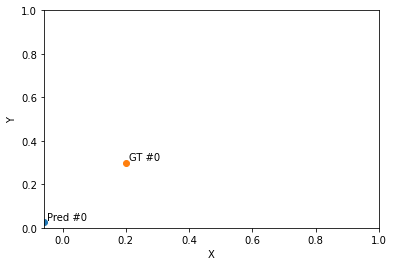

In [3]:
true_gaze = np.array([0.2,0.3], dtype=np.float32)
gaze_label = torch.from_numpy(true_gaze).unsqueeze(0)
gu.plot_gaze([net_output, gaze_label], ['Pred', 'GT'])

Now we should force the network to predict our desired gaze. We create optimizer and loss criterion. The optimizer adjusts the network parameters (weights) to minimize the loss computed by the criterion.

In [4]:
# Create an optimizer.
optim = torch.optim.Adam(lr=1e-3, params=model.parameters())

# Criterion.
criterion = nn.MSELoss()
loss = criterion(net_output, gaze_label)
print(f'Loss value = {loss}')

# Try manually
print(((net_output - gaze_label)**2).mean())

Loss value = 0.07108505815267563
tensor(0.0711, grad_fn=<MeanBackward0>)


Execute optimizer. It uses the gradient computed from the loss to improve the network params (weights) using gradient descent.

If you get an error, you likely already computed the gradients and deleted the execution tree. You can fix this by rerunning the model and recomputing the loss.

In [5]:
# Clear gradient cache.
optim.zero_grad()
# Compute new gradients.
loss.backward()
# Make a step: weights = weights - alpha * gradients
optim.step()

We can now call the model again and it will use the new parameters. If we recompute the loss, it should now be lower.

Loss before = 0.07108505815267563
Loss after = 0.019330788403749466


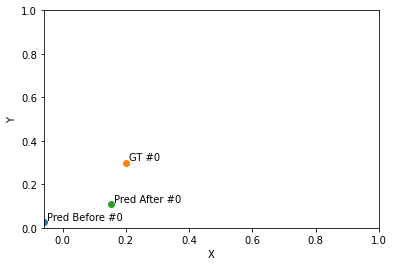

In [6]:
# Re-evaluate the loss.
net_output_2 = model(net_input)

# Print.
print(f'Loss before = {loss}')
print(f'Loss after = {criterion(net_output_2, gaze_label)}')
gu.plot_gaze([net_output, true_gaze, net_output_2], ['Pred Before', 'GT', 'Pred After'])

The idea of training is to repeat the optimization step many times.

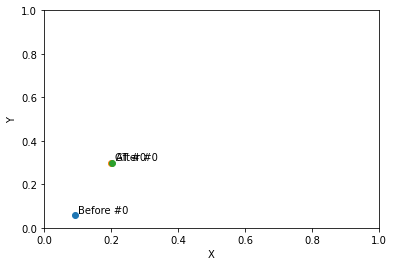

In [7]:
# Re-initialize the model and optimizer.
model = SimpleGazePredictor()
optim = torch.optim.Adam(lr=1e-4, params=model.parameters())

# Store initial output for comparison.
net_output_0 = model(net_input)

# Repeat 50 times.
for epoch in range(50):
    # Execute the model.
    net_output = model(net_input)

    # Compute loss.
    loss = criterion(net_output, gaze_label)

    # Update the model parameters.
    optim.zero_grad()
    loss.backward()
    optim.step()

gu.plot_gaze([net_output_0, gaze_label, net_output], ['Before', 'GT', 'After'])


However, since we have only trained with a single image, we have completely overfitted the network to a single prediction. If we give it a mirrored image we would expect a mirred prediction. Instead, we get mostly the same prediction. The network simply assumes that we ask it to always predict the single gt label it has ever seen.

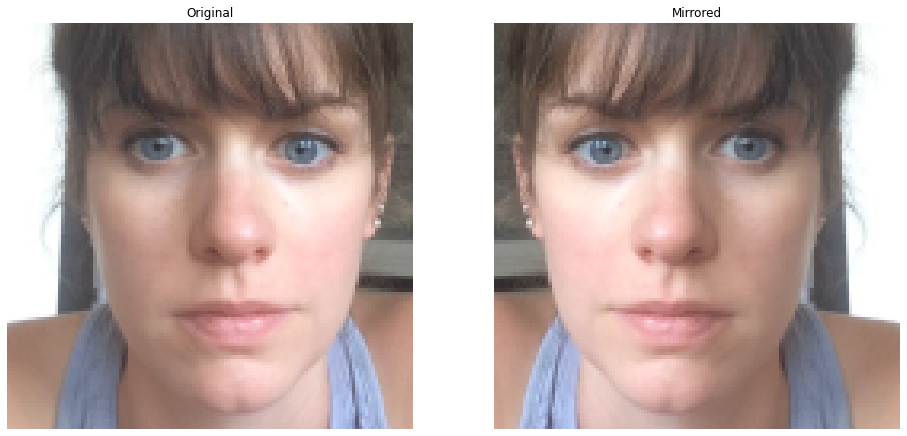

In [8]:
# Flip the eye, show the difference => will be biased.
net_input_mirrored = torch.flip(net_input.detach(), [3]).requires_grad_(True) # B, C, H, W => invert the last dimension (width)
gu.show_images([
    net_input[0] * 0.5 + 0.5, 
    net_input_mirrored[0] * 0.5 + 0.5,
    ], ['Original', 'Mirrored'])

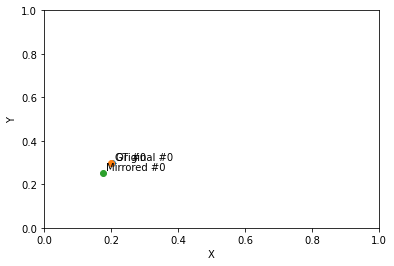

In [9]:
# Evaluate the mirrored image.
net_output_mirrored = model(net_input_mirrored)

# Plot for comparison.
gu.plot_gaze([net_output, gaze_label, net_output_mirrored], ['Original', 'GT', 'Mirrored'])

The solution is to train with more than one training image. To do that, in the next section we will build an image dataset.